In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [3]:
deliveries = pd.read_csv('../data/clean/deliveries.csv')

In [4]:
routes_df = pd.read_csv('../data/clean/routes.csv')

In [5]:
date_fields = [
  "pickup_dt", "max_pickup_dt", "pickup_arrival_dt", "pickup_effective_dt", 
  "delivery_dt", "max_delivery_dt", "delivery_arrival_dt", "delivery_effective_dt"
]
for field in date_fields:
  deliveries[field] = pd.to_datetime(deliveries[field])

In [6]:
deliveries["retraso_delivery"] = (deliveries["delivery_effective_dt"] - deliveries["max_delivery_dt"]).dt.total_seconds() / 3600
deliveries["retraso_pickup"] = (deliveries["pickup_effective_dt"] - deliveries["max_pickup_dt"]).dt.total_seconds() / 3600
deliveries["is_delayed_delivery"] = deliveries["retraso_delivery"] > 0
deliveries["is_delayed_pickup"] = deliveries["retraso_pickup"] > 0

In [7]:
df_m = deliveries.merge(routes_df, on="route_id")
df_m.head()

,id,route_id,state,_status,items,total_size,pickupLat,pickupLng,deliveryLat,deliveryLng,...,shipper_id,distance_charged,distance_route,total_package_price,vehicle_capacity,retraso_delivery,retraso_pickup,is_delayed_delivery,is_delayed_pickup,route_capacity
0,t-amabrt-1743660,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004818881','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4522,-44.2543,...,247379.0,0.3,0.3,19.72,2.0,0.172778,-0.375833,True,False,3
1,t-amabrt-1743667,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004810225','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4372,-44.2292,...,247379.0,0.6,0.6,39.90,2.0,-7.935556,-0.375833,False,False,3
2,t-amabrt-1743673,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004807779','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4381,-44.2479,...,247379.0,0.7,0.7,30.23,2.0,-5.369444,-0.375833,False,False,3
3,t-amabrt-1743742,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004819106','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4258,-44.2426,...,247379.0,0.6,0.6,41.44,2.0,-13.520556,-0.375833,False,False,3
4,t-amabrt-1743835,r-shiinc-1248026,7,completed,"[{'id':'SFYBR004811623','qty':1,'name':'CAIXA'...",2,-19.9618,-44.0285,-19.4434,-44.2558,...,247379.0,0.3,0.3,84.79,2.0,-3.652500,-0.375833,False,False,3


In [8]:
#x = experiencia
#y = retraso

df_shippers = df_m.groupby("shipper_id").agg({"route_id":"nunique"}).reset_index()
df_shippers.columns= ["shipper_id", "expertise"]
df_shippers

,shipper_id,expertise
0,238.0,21
1,984.0,33
2,3134.0,2
3,6995.0,1
4,11277.0,1
...,...,...
397,402581.0,1
398,402635.0,2
399,402949.0,2
400,403140.0,1


In [9]:
df_retr_ship = deliveries.groupby(["shipper_id"]).agg({"is_delayed_delivery":np.sum, "id":"count"}).reset_index()
df_retr_ship["percentage"] = (df_retr_ship["is_delayed_delivery"] / df_retr_ship["id"])*100
df_retr_ship.head()

,shipper_id,is_delayed_delivery,id,percentage
0,238.0,29,451,6.430155
1,984.0,102,265,38.490566
2,3134.0,0,38,0.000000
3,6995.0,15,35,42.857143
4,11277.0,0,43,0.000000


In [10]:
dfm_shippers = df_shippers.merge(df_retr_ship, on="shipper_id")
dfm_shippers.head()

,shipper_id,expertise,is_delayed_delivery,id,percentage
0,238.0,21,29,451,6.430155
1,984.0,33,102,265,38.490566
2,3134.0,2,0,38,0.000000
3,6995.0,1,15,35,42.857143
4,11277.0,1,0,43,0.000000


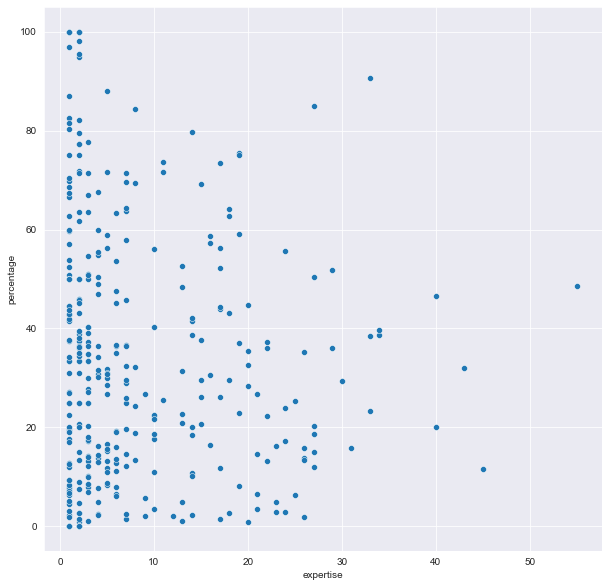

In [11]:
_ = sns.set_style("darkgrid")
ax, fig = plt.subplots(figsize=(10,10))
_ = sns.scatterplot(x="expertise", y="percentage", data=dfm_shippers)

In [12]:
dfm_shippers["expertise"].corr(dfm_shippers["percentage"])

-0.020305875492695483

In [13]:
def delays_by_day_fn(dt_field, is_delayed_field, deliveries):
    delays_by_day = deliveries.groupby(deliveries[dt_field].dt.day_of_week).agg({is_delayed_field:np.sum,"id":"count"}).reset_index()
    delays_by_day["percentage"] = (delays_by_day[is_delayed_field] / delays_by_day["id"])*100
    delays_by_day.columns = ["day","delayed_count","total_count","percentage"]
    delays_by_day["day"] = delays_by_day["day"].map({0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})
    return delays_by_day

In [14]:
def graph_barplot(df, x_label, title):
    ax, fig = plt.subplots(figsize=(10,7))
    _ = sns.set_style("darkgrid")
    _ = sns.barplot(data=df, x="percentage", y="day", palette="crest")
    _ = plt.xlabel(x_label)
    _ = plt.title(title)

In [15]:
deliv_delays_by_day = delays_by_day_fn("delivery_effective_dt","is_delayed_delivery",deliveries)
pickup_delays_by_day = delays_by_day_fn("pickup_effective_dt","is_delayed_pickup",deliveries)
print(pickup_delays_by_day)

         day  delayed_count  total_count  percentage
0     Monday           2875        20188   14.241133
1    Tuesday           3215        17306   18.577372
2  Wednesday           3375        16908   19.960965
3   Thursday           5240        13111   39.966440
4     Friday           2326        13007   17.882679
5   Saturday            881         7305   12.060233
6     Sunday           1107         2329   47.531129


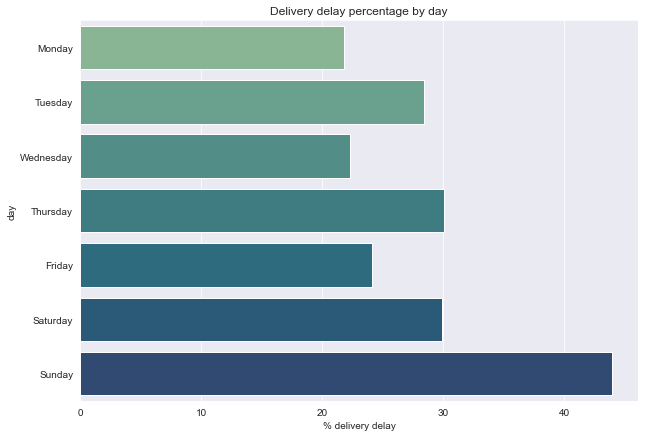

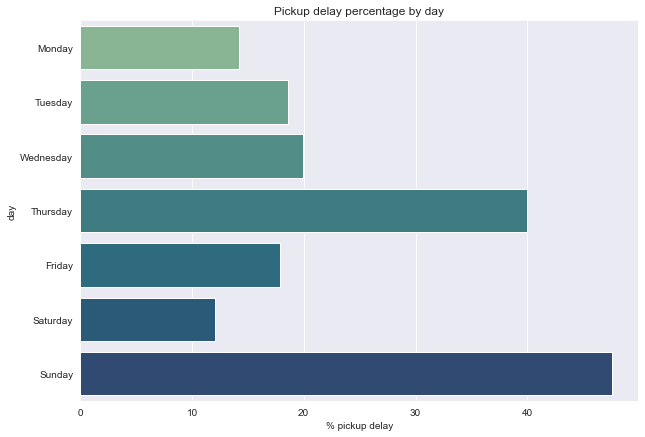

In [16]:
graph_barplot(deliv_delays_by_day, "% delivery delay", "Delivery delay percentage by day")
graph_barplot(pickup_delays_by_day, "% pickup delay", "Pickup delay percentage by day")